In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, format_timedelta, Locale
import locale                                    # para tratar de poner espanol
#locale = Locale('es', 'CL')
locale.setlocale(locale.LC_ALL,'es_ES.UTF-8')  

import os
import runpy
from pyexcel_ods import get_data

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

#importo sólo algunas de mis funciones, dejo otras excluídas....

In [2]:
# cargo algunos scripts que me suelen servir para análisis

In [3]:
#listo los archivos
scripts = []
for dirname, dirnames, filenames in os.walk('/home/egidio/Dropbox/Compucosas/programas py'):
    for filename in filenames:
        scripts.append(os.path.join(dirname, filename))

scripts

# los cargo
for script in scripts:
    if script[-3:] == '.py':
        exec(open(str(script)).read())

['/home/egidio/Dropbox/Compucosas/programas py/lector_ODF.py',
 '/home/egidio/Dropbox/Compucosas/programas py/como importar',
 '/home/egidio/Dropbox/Compucosas/programas py/descripcion_univariada.py',
 '/home/egidio/Dropbox/Compucosas/programas py/características_operativas_de_test.py',
 '/home/egidio/Dropbox/Compucosas/programas py/percentiles.py',
 '/home/egidio/Dropbox/Compucosas/programas py/tabala_frecuencias.py',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/percentiles.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/lector_ODF.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/descripcion_univariada.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/características_operativas_de_test.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/tabala_frecuencias.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/funciones_locales.cpython-36.pyc']

# Busco las BDs diponibles

Busco las BD siponibles en la carpeta./BD, las que buscaré y las juntaré en un solo archivo

In [8]:
datos = []
for dirname, dirnames, filenames in os.walk('./BD/'):
    for filename in filenames:
        datos.append(os.path.join(dirname, filename))
datos

['./BD/SAMU 01-01-2018 al 31-12-2018.xlsx',
 './BD/eSAMU.pkl',
 './BD/SAMU 01-01-2019 al 31-12-2019.xlsx']

selecciono algunos...

In [9]:
archivos_eSAMU = [f for f in datos if '.xls' in f]

dejo todo lo que tengo como un solo objeto: BD

In [10]:
BD = pd.DataFrame()
for f in archivos_eSAMU:
    data = pd.read_excel(f)
    BD = BD.append(data)
BD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100662 entries, 0 to 53351
Data columns (total 44 columns):
Id                          100662 non-null int64
Fecha                       100662 non-null object
Motivo del Llamado          100655 non-null object
Submotivo del Llamado       100655 non-null object
Prioridad                   74397 non-null object
Estado                      100662 non-null object
Edad                        96050 non-null float64
Género                      95588 non-null object
Dirección                   88487 non-null object
Sector                      69549 non-null object
Comuna                      92336 non-null object
Región                      98072 non-null object
Intervención                100662 non-null object
Tipo Traslado               100662 non-null object
Categoría Vehículo          40497 non-null object
Condición Traslado          100662 non-null object
En Regulación               51241 non-null object
En Despacho                 7083

# Comienzo a arreglar base de datos

dejo como numérica la edad, que lo unico que encontré

In [11]:
variables_a_numericos = [      # elijo las variables que debo transformar a numérico
    "Edad"
]

for variable in variables_a_numericos:
    BD[variable] = pd.to_numeric(BD[variable])

del variables_a_numericos

## Arreglo: Fechas

transformo a fecha tipo datetime64 la fecha que actualmente aparece

In [12]:
BD['Fecha'] = pd.to_datetime(
    BD['Fecha'],
    format='%d-%m-%Y %H:%M:%S')

In [25]:
BD['Fecha'].describe()

count                  100662
unique                  87605
top       2018-11-23 14:30:10
freq                      442
first     2018-01-15 08:45:15
last      2019-12-31 23:53:37
Name: Fecha, dtype: object

Luego defino aquellas variables que debo hacer algo similar

In [13]:
variables_a_fecha = [
    'Móvil Agregado',
    'Móvil Despachado', 'Móvil Salida', 'Móvil Llegada Lugar',
    'Móvil en Traslado', 'Móvil Llegada a CA', 'Móvil Recepción Paciente', 'Móvil Camilla Retenida',
    'Móvil Vuelta a Base', 'Móvil LLegada a Base',
    'Móvil Finalizado'
]

ahora lo hago

In [14]:
for variable in variables_a_fecha:
    BD[variable] = pd.to_datetime(
        BD[variable],
        format='%Y-%m-%d %H:%M:%S', 
    errors='coerce')

In [15]:
BD['Diff_recep_Despachado'] = (BD['Móvil Despachado'] - BD['Fecha'])
BD['Diff_Despacho_Salida'] = (BD['Móvil Salida'] - BD['Móvil Despachado'])
BD['Diff_salida_enellugar'] = (BD['Móvil Llegada Lugar'] - BD['Móvil Salida'])
BD['Diff_z6_1'] = (BD['Móvil Camilla Retenida'] - BD['Móvil Despachado'])
BD['Diff_z6_2'] = (BD['Móvil Vuelta a Base'] - BD['Móvil Camilla Retenida'])
BD['Diff_z6_3'] = (BD['Móvil LLegada a Base'] - BD['Móvil Camilla Retenida'])

BD['Diff_recep_Despachado'] = (BD['Móvil Despachado'] - BD['Fecha'])
BD['Diff_Despacho_Salida'] = (BD['Móvil Salida'] - BD['Móvil Despachado'])
BD['Diff_salida_enellugar'] = (BD['Móvil Llegada Lugar'] - BD['Móvil Salida'])
BD['Diff_z6_1'] = (BD['Móvil Camilla Retenida'] - BD['Móvil Despachado'])
BD['Diff_z6_2'] = (BD['Móvil Vuelta a Base'] - BD['Móvil Camilla Retenida'])
BD['Diff_z6_3'] = (BD['Móvil LLegada a Base'] - BD['Móvil Camilla Retenida'])

In [16]:
tiempos = ['Fecha',
           'Móvil Agregado',
           'Móvil Despachado', 'Móvil Salida', 'Móvil Llegada Lugar',
           'Móvil en Traslado', 'Móvil Llegada a CA', 'Móvil Recepción Paciente', 'Móvil Camilla Retenida',
           'Móvil Vuelta a Base', 'Móvil LLegada a Base',
           'Móvil Finalizado']

diferenciales = ['Diff_recep_Despachado',
                 'Diff_Despacho_Salida',
                 'Diff_salida_enellugar',
                 'Diff_z6_1',
                 'Diff_z6_2', 
                 'Diff_z6_3']

tiempos.append('Nombre Vehículo')
tiempos.append('Id')

BD[tiempos].head(2)
BD[diferenciales].head(2)

,Fecha,Móvil Agregado,Móvil Despachado,Móvil Salida,Móvil Llegada Lugar,Móvil en Traslado,Móvil Llegada a CA,Móvil Recepción Paciente,Móvil Camilla Retenida,Móvil Vuelta a Base,Móvil LLegada a Base,Móvil Finalizado,Nombre Vehículo,Id
0,2018-12-31 23:46:09,NaT,2019-01-01 03:47:36,NaT,2019-01-01 03:47:44,NaT,NaT,NaT,NaT,2019-01-01 04:40:59,NaT,2019-01-01 04:42:14,R31,62921
1,2018-12-31 23:27:29,NaT,2019-01-01 02:36:20,2019-01-01 02:44:09,2019-01-01 02:54:45,2019-01-01 03:14:12,2019-01-01 03:29:29,2019-01-01 03:29:32,NaT,NaT,2019-01-01 03:47:01,2019-01-01 03:47:09,R24,62920


,Diff_recep_Despachado,Diff_Despacho_Salida,Diff_salida_enellugar,Diff_z6_1,Diff_z6_2,Diff_z6_3
0,04:01:27,NaT,NaT,NaT,NaT,NaT
1,03:08:51,00:07:49,00:10:36,NaT,NaT,NaT


count                  100662
unique                  87605
top       2018-11-23 14:30:10
freq                      442
first     2018-01-15 08:45:15
last      2019-12-31 23:53:37
Name: Fecha, dtype: object

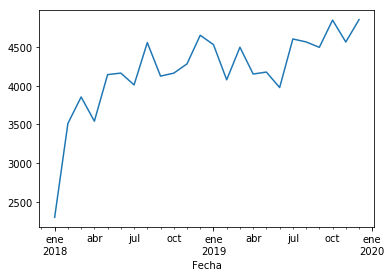

In [17]:
BD.Fecha.describe()
BD.groupby(BD.Fecha.dt.to_period('M')).Id.count().plot()

## Arreglo: números negativos segun tiempos

Dado los cálculos realizados, encuentro que hay diferencias horarias que son negativas, que no explican lo que está pasando. por lo que quiero saber cuantos n negativos existen

In [18]:
for dumm in diferenciales:
    tab_frec(BD[dumm] < pd.Timedelta(0))

,n,%
Diff_recep_Despachado,,
False,100662,100.0
Total,100662,100.0


,n,%
Diff_Despacho_Salida,,
False,100659,100.0
True,3,0.0
Total,100662,100.0


,n,%
Diff_salida_enellugar,,
False,100608,99.95
True,54,0.05
Total,100662,100.00


,n,%
Diff_z6_1,,
False,100659,100.0
True,3,0.0
Total,100662,100.0


,n,%
Diff_z6_2,,
False,100201,99.54
True,461,0.46
Total,100662,100.00


,n,%
Diff_z6_3,,
False,99510,98.86
True,1152,1.14
Total,100662,100.00


Ahora excluiré aquellas entradas con valores negativos de la BD

In [19]:
for dumm in diferenciales:
    BD.loc[BD[dumm] < pd.Timedelta('0 days'),dumm] = np.nan

Ahora veré los tiempos sin contaminación

In [20]:
for dumm in diferenciales:
    tab_frec(BD[dumm] < pd.Timedelta(0))
    BD[dumm].describe()

,n,%
Diff_recep_Despachado,,
False,100662,100.0
Total,100662,100.0


count                     47485
mean     0 days 04:20:35.130757
std      0 days 03:39:16.411994
min             0 days 03:00:09
25%             0 days 03:09:38
50%             0 days 03:57:42
75%             0 days 04:24:29
max            13 days 18:06:32
Name: Diff_recep_Despachado, dtype: object

,n,%
Diff_Despacho_Salida,,
False,100662,100.0
Total,100662,100.0


count                     37590
mean     0 days 00:07:54.635301
std      0 days 00:19:10.988734
min             0 days 00:00:02
25%             0 days 00:00:47
50%             0 days 00:03:03
75%             0 days 00:07:49
max             1 days 02:44:39
Name: Diff_Despacho_Salida, dtype: object

,n,%
Diff_salida_enellugar,,
False,100662,100.0
Total,100662,100.0


count                     30242
mean     0 days 00:15:40.335559
std      0 days 00:21:10.951918
min             0 days 00:00:01
25%             0 days 00:05:01
50%             0 days 00:10:28
75%      0 days 00:18:32.750000
max             0 days 15:34:05
Name: Diff_salida_enellugar, dtype: object

,n,%
Diff_z6_1,,
False,100662,100.0
Total,100662,100.0


count                      5236
mean     0 days 01:41:15.628533
std      0 days 01:02:51.907268
min             0 days 00:00:03
25%      0 days 01:02:47.750000
50%      0 days 01:26:39.500000
75%             0 days 02:01:15
max             0 days 12:34:30
Name: Diff_z6_1, dtype: object

,n,%
Diff_z6_2,,
False,100662,100.0
Total,100662,100.0


count                       763
mean     0 days 01:54:24.233289
std      0 days 02:20:48.743514
min             0 days 00:00:02
25%             0 days 00:18:57
50%             0 days 01:08:03
75%      0 days 02:29:08.500000
max             0 days 15:18:50
Name: Diff_z6_2, dtype: object

,n,%
Diff_z6_3,,
False,100662,100.0
Total,100662,100.0


count                      1958
mean     0 days 02:13:13.987231
std      0 days 02:27:01.656175
min             0 days 00:00:02
25%      0 days 00:37:09.500000
50%             0 days 01:24:25
75%             0 days 02:58:03
max             1 days 04:20:28
Name: Diff_z6_3, dtype: object

# Esporto la BD

In [21]:
BD.to_pickle('./BD/eSAMU.pkl')

# Datos generales

In [22]:
BD.columns

Index(['Id', 'Fecha', 'Motivo del Llamado', 'Submotivo del Llamado',
       'Prioridad', 'Estado', 'Edad', 'Género', 'Dirección', 'Sector',
       'Comuna', 'Región', 'Intervención', 'Tipo Traslado',
       'Categoría Vehículo', 'Condición Traslado', 'En Regulación',
       'En Despacho', 'En Curso', 'Atendida', 'Completado', 'Regulado',
       'Usuario que Cierra', 'Móvil Agregado', 'Móvil Despachado',
       'Móvil Salida', 'Móvil Llegada Lugar', 'Móvil en Traslado',
       'Móvil Llegada a CA', 'Móvil Recepción Paciente',
       'Móvil Camilla Retenida', 'Móvil Vuelta a Base', 'Móvil LLegada a Base',
       'Móvil Finalizado', 'Nombre Vehículo', 'Tipo Requerido',
       'Tipo Despachado', 'Km Recorrido', 'Chofer', 'Paramédico', 'Enfermero',
       'Doctor', 'Longitud', 'Latitud', 'Diff_recep_Despachado',
       'Diff_Despacho_Salida', 'Diff_salida_enellugar', 'Diff_z6_1',
       'Diff_z6_2', 'Diff_z6_3'],
      dtype='object')

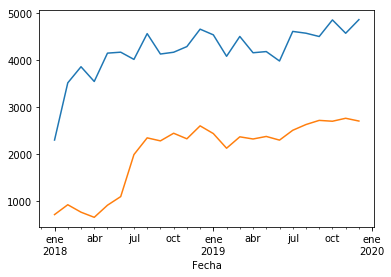

In [23]:
BD.groupby(BD.Fecha.dt.to_period('M')).Id.count().plot()
BD.groupby(BD.Fecha.dt.to_period('M'))['Nombre Vehículo'].count().plot()

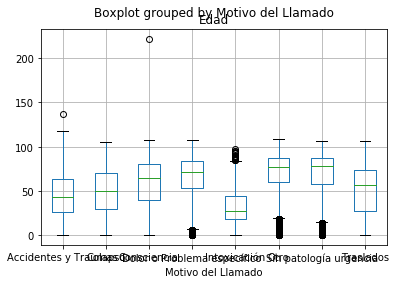

In [24]:
BD.boxplot('Edad', by = 'Motivo del Llamado')
